# Ground Truth vs Simulation Comparison

Compare Ground Truth log (BPI Challenge 2017) with the latest simulated log from integration/output

In [1]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Load Event Logs

In [3]:
# Load Ground Truth log from integration/output
print("Loading Ground Truth log...")
try:
    log_gt = pm4py.read_xes('integration/output/ground_truth_log.xes')
    df_gt = pm4py.convert_to_dataframe(log_gt)
    print(f"Ground Truth (XES): {len(df_gt)} events, {df_gt['case:concept:name'].nunique()} cases")
except:
    df_gt = pd.read_csv('integration/output/ground_truth_log.csv')
    print(f"Ground Truth (CSV): {len(df_gt)} events, {df_gt['case:concept:name'].nunique()} cases")

# Load Simulated log from integration/output
print("\nLoading Simulated log...")
try:
    log_sim = pm4py.read_xes('integration/output/simulated_log.xes')
    df_sim = pm4py.convert_to_dataframe(log_sim)
    print(f"Simulation (XES): {len(df_sim)} events, {df_sim['case:concept:name'].nunique()} cases")
except:
    df_sim = pd.read_csv('integration/output/simulated_log.csv')
    print(f"Simulation (CSV): {len(df_sim)} events, {df_sim['case:concept:name'].nunique()} cases")

print(f"\n✓ Both logs loaded successfully")

Loading Ground Truth log...
Ground Truth (XES): 39932 events, 1000 cases

Loading Simulated log...
Simulation (XES): 14377 events, 1000 cases

✓ Both logs loaded successfully


## 2. Basic Statistics Comparison

In [5]:
def get_log_statistics(df, name):
    stats = {
        'Log': name,
        'Total Events': len(df),
        'Total Cases': df['case:concept:name'].nunique(),
        'Unique Activities': df['concept:name'].nunique(),
        'Avg Events per Case': len(df) / df['case:concept:name'].nunique(),
    }
    
    # Case duration statistics
    df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], format='mixed')
    case_durations = df.groupby('case:concept:name')['time:timestamp'].agg(['min', 'max'])
    case_durations['duration_hours'] = (case_durations['max'] - case_durations['min']).dt.total_seconds() / 3600
    
    stats['Avg Case Duration (hours)'] = case_durations['duration_hours'].mean()
    stats['Median Case Duration (hours)'] = case_durations['duration_hours'].median()
    stats['Min Case Duration (hours)'] = case_durations['duration_hours'].min()
    stats['Max Case Duration (hours)'] = case_durations['duration_hours'].max()
    
    return stats

stats_gt = get_log_statistics(df_gt.copy(), "Ground Truth")
stats_sim = get_log_statistics(df_sim.copy(), "Simulation")

# Create difference row
stats_diff = {'Log': '△ (Sim - GT)'}
for key in stats_gt.keys():
    if key != 'Log':
        stats_diff[key] = stats_sim[key] - stats_gt[key]

comparison_df = pd.DataFrame([stats_gt, stats_sim, stats_diff])

print("="*80)
print("BASIC STATISTICS COMPARISON")
print("="*80)
display(comparison_df)

# Calculate percentage differences
print("\nPercentage Differences (Simulation vs Ground Truth):")
print(f"Cases: {(stats_sim['Total Cases'] - stats_gt['Total Cases']) / stats_gt['Total Cases'] * 100:.1f}%")
print(f"Events: {(stats_sim['Total Events'] - stats_gt['Total Events']) / stats_gt['Total Events'] * 100:.1f}%")
print(f"Avg Events per Case: {(stats_sim['Avg Events per Case'] - stats_gt['Avg Events per Case']) / stats_gt['Avg Events per Case'] * 100:.1f}%")

BASIC STATISTICS COMPARISON


,Log,Total Events,Total Cases,Unique Activities,Avg Events per Case,Avg Case Duration (hours),Median Case Duration (hours),Min Case Duration (hours),Max Case Duration (hours)
0,Ground Truth,39932,1000,24,39.932,555.876196,403.617685,0.173673,3251.708139
1,Simulation,14377,1000,25,14.377,5765.027224,4825.650434,50.888499,16445.741748
2,△ (Sim - GT),-25555,0,1,-25.555,5209.151028,4422.032748,50.714826,13194.033609



Percentage Differences (Simulation vs Ground Truth):
Cases: 0.0%
Events: -64.0%
Avg Events per Case: -64.0%


## 3. Activity Frequency Comparison

ACTIVITY FREQUENCY COMPARISON


,Ground Truth,Simulation,Difference,% Diff
concept:name,,,,
W_Validate application,7713.0,417,-7296.0,-94.6
W_Call after offers,6102.0,957,-5145.0,-84.3
W_Complete application,5180.0,1314,-3866.0,-74.6
W_Call incomplete files,4993.0,108,-4885.0,-97.8
W_Handle leads,1559.0,830,-729.0,-46.8
O_Create Offer,1528.0,1098,-430.0,-28.1
O_Created,1528.0,1098,-430.0,-28.1
O_Sent (mail and online),1418.0,838,-580.0,-40.9
A_Validating,1221.0,321,-900.0,-73.7


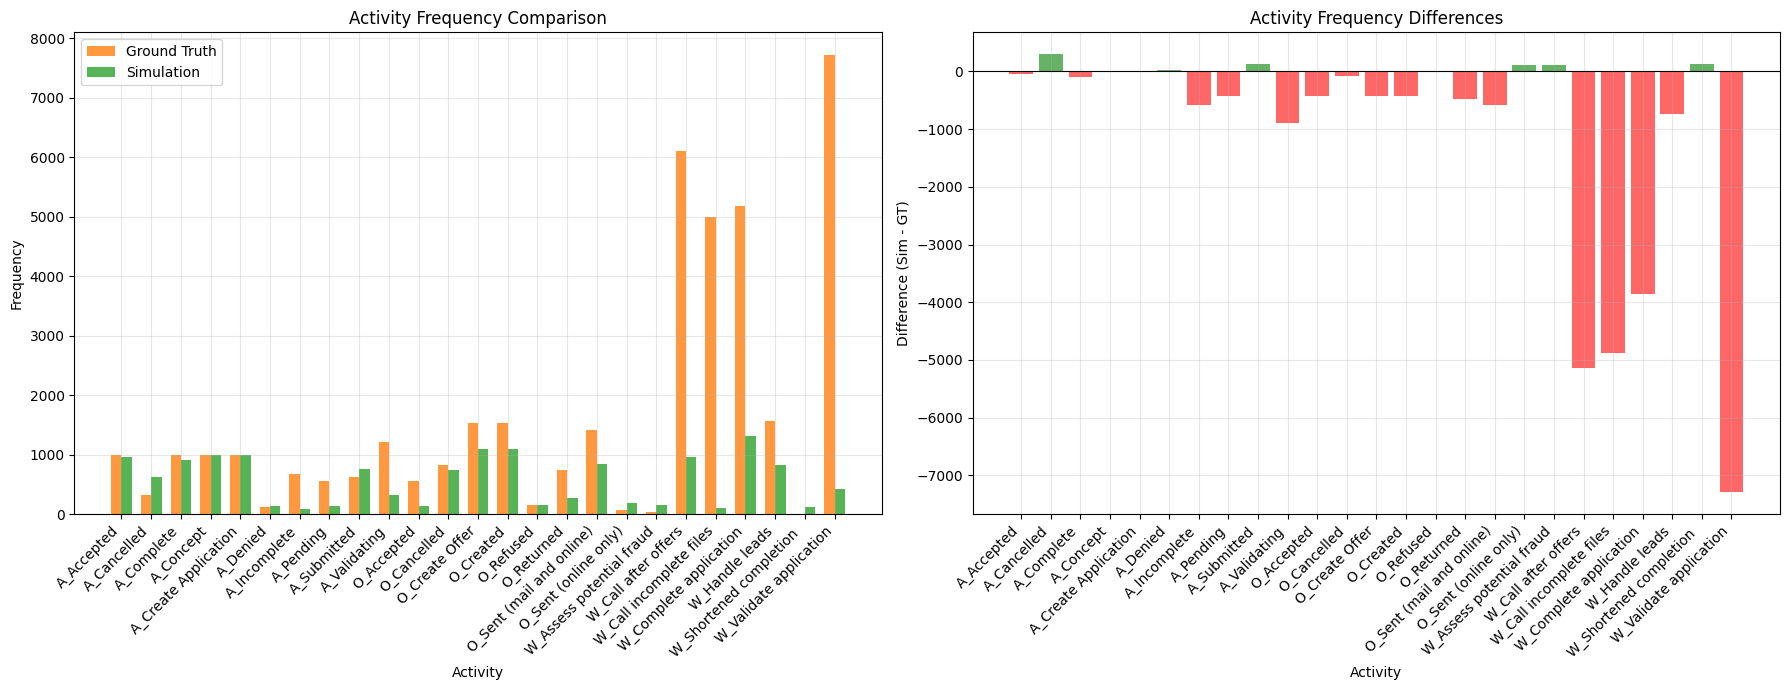

In [6]:
# Activity frequencies
activity_freq_gt = df_gt['concept:name'].value_counts().sort_index()
activity_freq_sim = df_sim['concept:name'].value_counts().sort_index()

# Combine into one DataFrame
activity_comparison = pd.DataFrame({
    'Ground Truth': activity_freq_gt,
    'Simulation': activity_freq_sim
}).fillna(0)

activity_comparison['Difference'] = activity_comparison['Simulation'] - activity_comparison['Ground Truth']
activity_comparison['% Diff'] = (activity_comparison['Difference'] / activity_comparison['Ground Truth'] * 100).round(1)

print("="*80)
print("ACTIVITY FREQUENCY COMPARISON")
print("="*80)
display(activity_comparison.sort_values('Ground Truth', ascending=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Bar chart comparison
x = np.arange(len(activity_comparison))
width = 0.35

ax1.bar(x - width/2, activity_comparison['Ground Truth'], width, label='Ground Truth', alpha=0.8, color='#ff7f0e')
ax1.bar(x + width/2, activity_comparison['Simulation'], width, label='Simulation', alpha=0.8, color='#2ca02c')
ax1.set_xlabel('Activity')
ax1.set_ylabel('Frequency')
ax1.set_title('Activity Frequency Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(activity_comparison.index, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Difference chart
colors = ['red' if x < 0 else 'green' for x in activity_comparison['Difference']]
ax2.bar(x, activity_comparison['Difference'], color=colors, alpha=0.6)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Activity')
ax2.set_ylabel('Difference (Sim - GT)')
ax2.set_title('Activity Frequency Differences')
ax2.set_xticks(x)
ax2.set_xticklabels(activity_comparison.index, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Variant Analysis

In [7]:
# Get process variants
def get_variants_analysis(df, name):
    log = pm4py.convert_to_event_log(df)
    variants = pm4py.get_variants(log)
    
    print(f"\n{name}:")
    print(f"Total unique variants: {len(variants)}")
    print(f"\nTop 15 variants by frequency:")
    
    sorted_variants = sorted(variants.items(), key=lambda x: len(x[1]), reverse=True)[:15]
    for i, (variant, cases) in enumerate(sorted_variants, 1):
        print(f"{i:2d}. ({len(cases):4d} cases) {variant}")
    
    return variants

print("="*80)
print("VARIANT ANALYSIS")
print("="*80)

variants_gt = get_variants_analysis(df_gt, "Ground Truth")
variants_sim = get_variants_analysis(df_sim, "Simulation")

# Find common and unique variants
variants_gt_keys = set(variants_gt.keys())
variants_sim_keys = set(variants_sim.keys())

common_variants = variants_gt_keys & variants_sim_keys
only_gt = variants_gt_keys - variants_sim_keys
only_sim = variants_sim_keys - variants_gt_keys

print(f"\n{'='*80}")
print(f"Common variants: {len(common_variants)}")
print(f"Only in Ground Truth: {len(only_gt)}")
print(f"Only in Simulation: {len(only_sim)}")
print(f"Variant coverage (Sim/GT): {len(variants_sim) / len(variants_gt) * 100:.1f}%")

VARIANT ANALYSIS

Ground Truth:
Total unique variants: 800

Top 15 variants by frequency:
 1. (  18 cases) ('A_Create Application', 'W_Complete application', 'W_Complete application', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'W_Call after offers', 'W_Call after offers', 'A_Complete', 'W_Call after offers', 'W_Call after offers', 'W_Call after offers', 'A_Cancelled', 'O_Cancelled', 'W_Call after offers')
 2. (  17 cases) ('A_Create Application', 'A_Submitted', 'W_Handle leads', 'W_Handle leads', 'W_Complete application', 'A_Concept', 'W_Complete application', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'W_Call after offers', 'W_Call after offers', 'A_Complete', 'W_Call after offers', 'W_Call after offers', 'W_Call after offers', 'A_Cancelled', 'O_Cancelled', 'W_Call after offers')
 3. (  15 cases) ('A_Create Application', 'A_Submitted', 'W_Handle leads', 'W_Handl

## 5. DFG Comparison

In [8]:
# Discover DFGs
print("Discovering Directly-Follows Graphs...")

log_gt_pm4py = pm4py.convert_to_event_log(df_gt)
dfg_gt, start_gt, end_gt = pm4py.discover_dfg(log_gt_pm4py)
print(f"Ground Truth: {len(dfg_gt)} DFG edges")

log_sim_pm4py = pm4py.convert_to_event_log(df_sim)
dfg_sim, start_sim, end_sim = pm4py.discover_dfg(log_sim_pm4py)
print(f"Simulation: {len(dfg_sim)} DFG edges")

print(f"\nEdge coverage (Sim/GT): {len(dfg_sim) / len(dfg_gt) * 100:.1f}%")

Discovering Directly-Follows Graphs...
Ground Truth: 109 DFG edges
Simulation: 103 DFG edges

Edge coverage (Sim/GT): 94.5%


Ground Truth DFG:


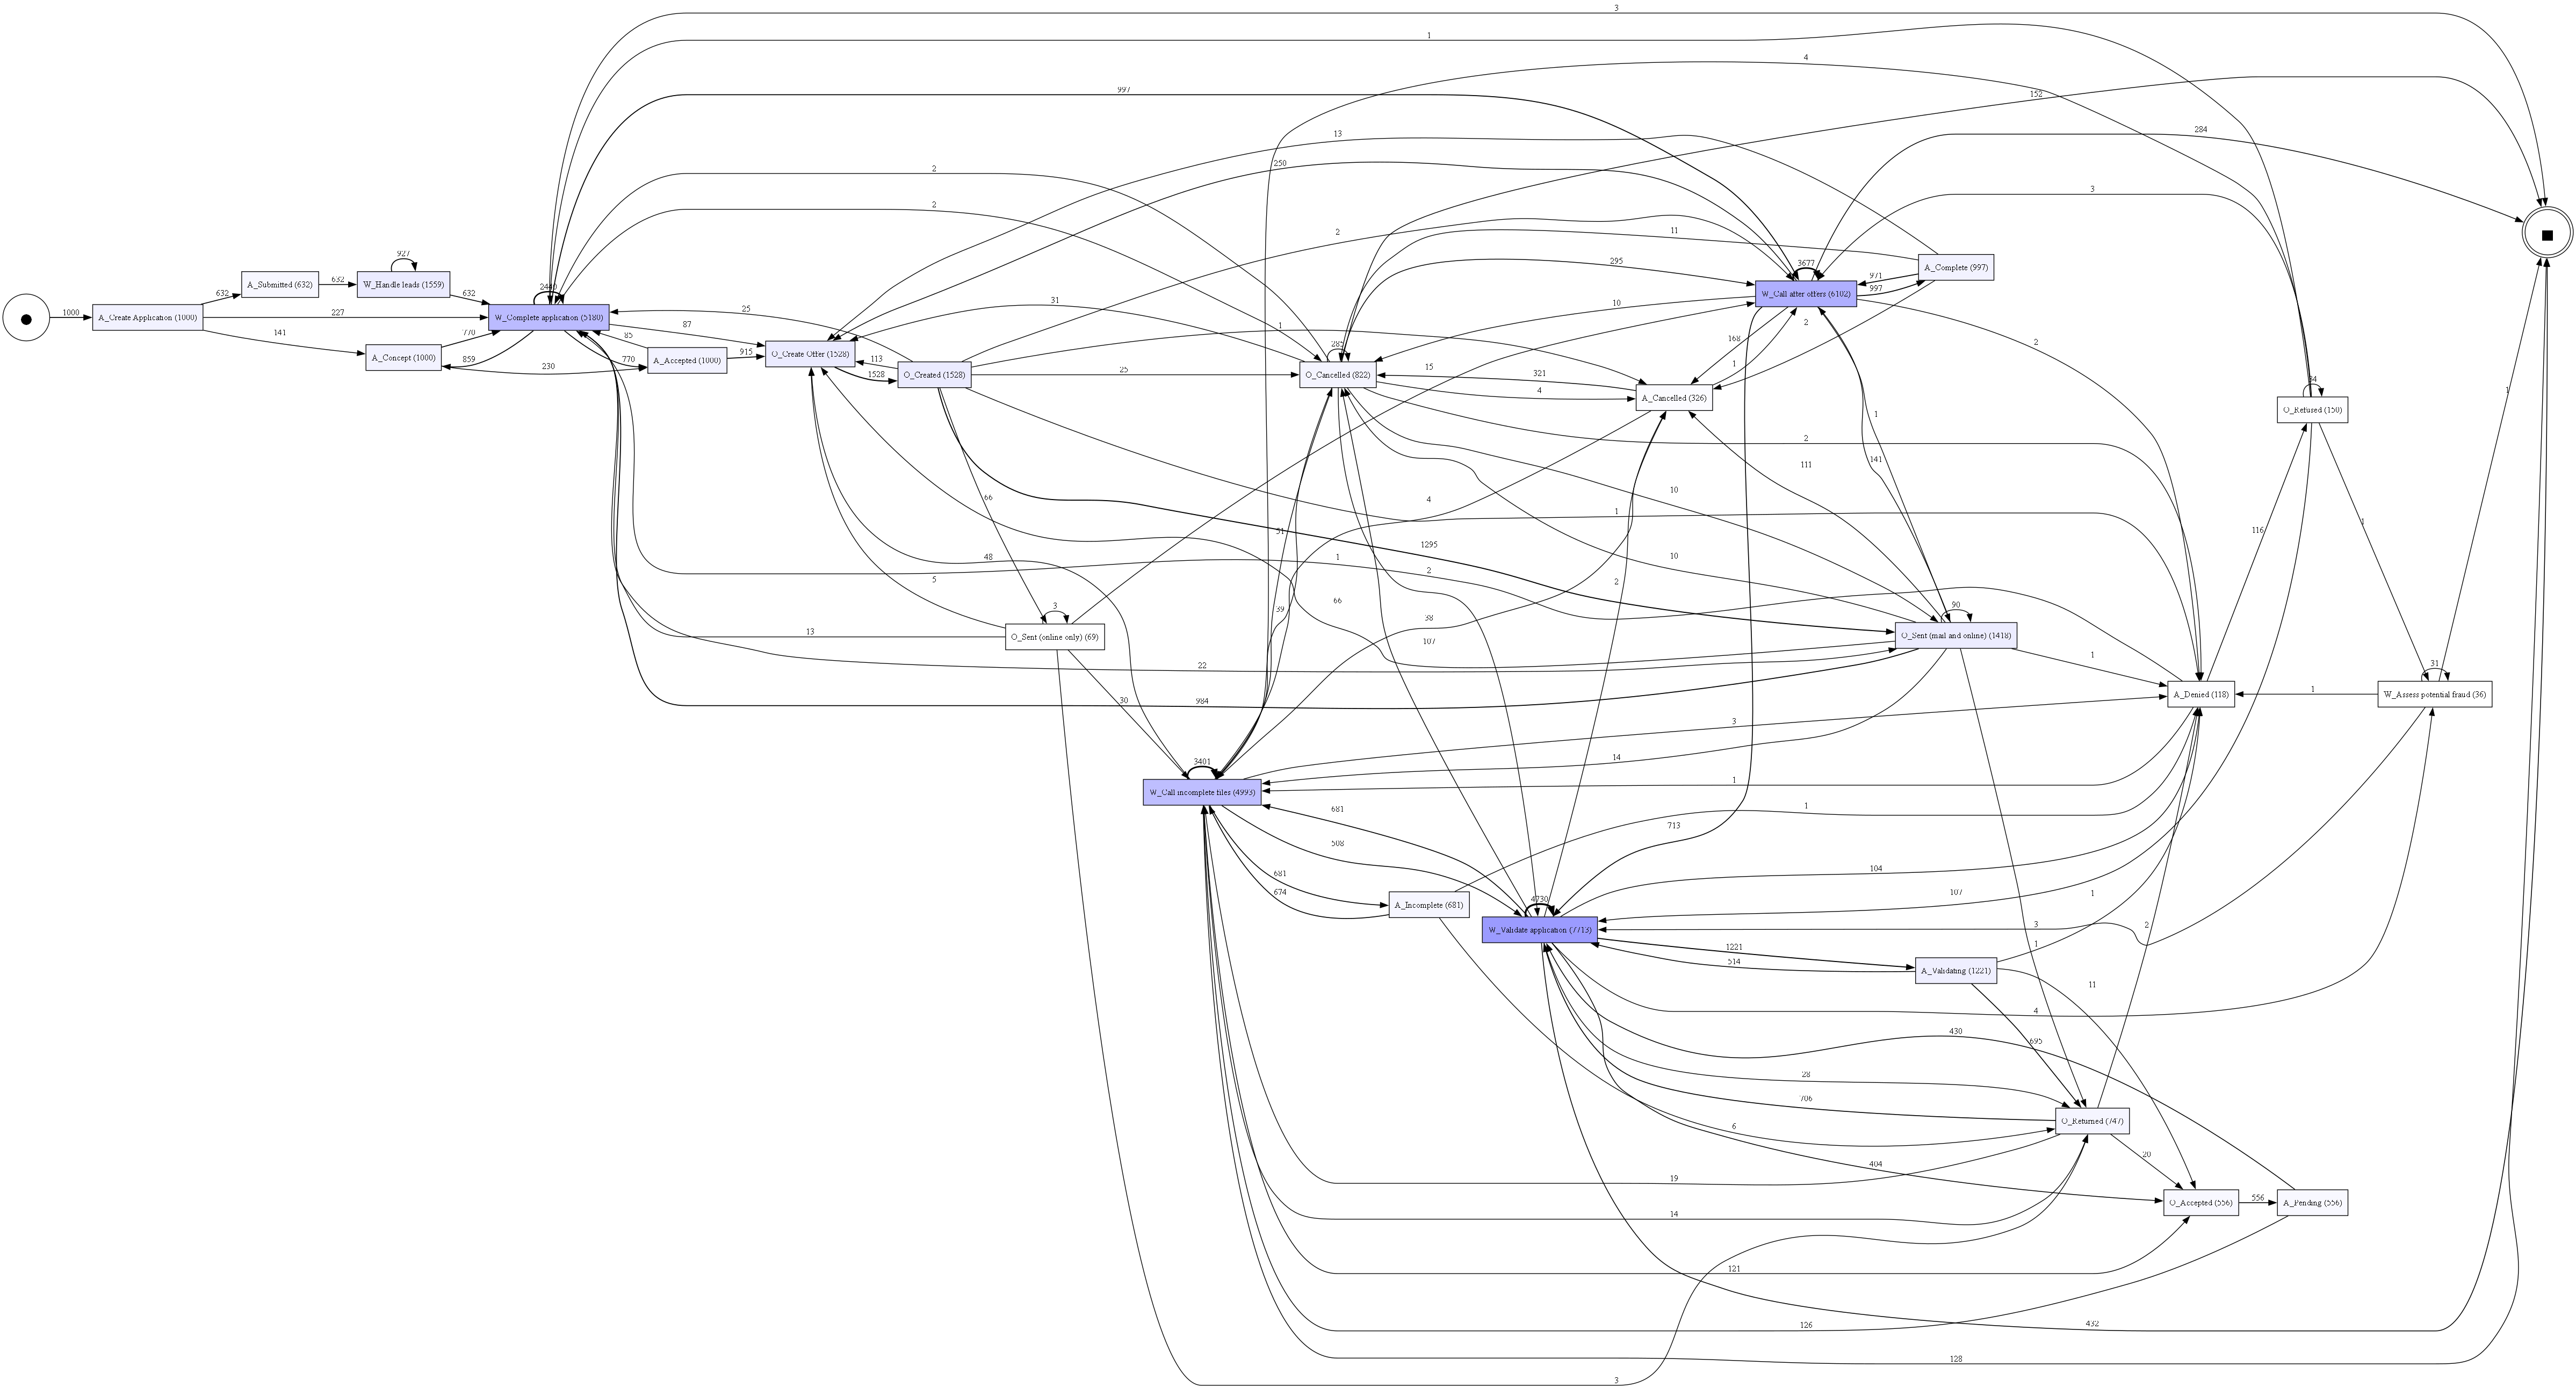

In [9]:
# Visualize Ground Truth DFG
print("Ground Truth DFG:")
pm4py.view_dfg(dfg_gt, start_gt, end_gt)

Simulation DFG:


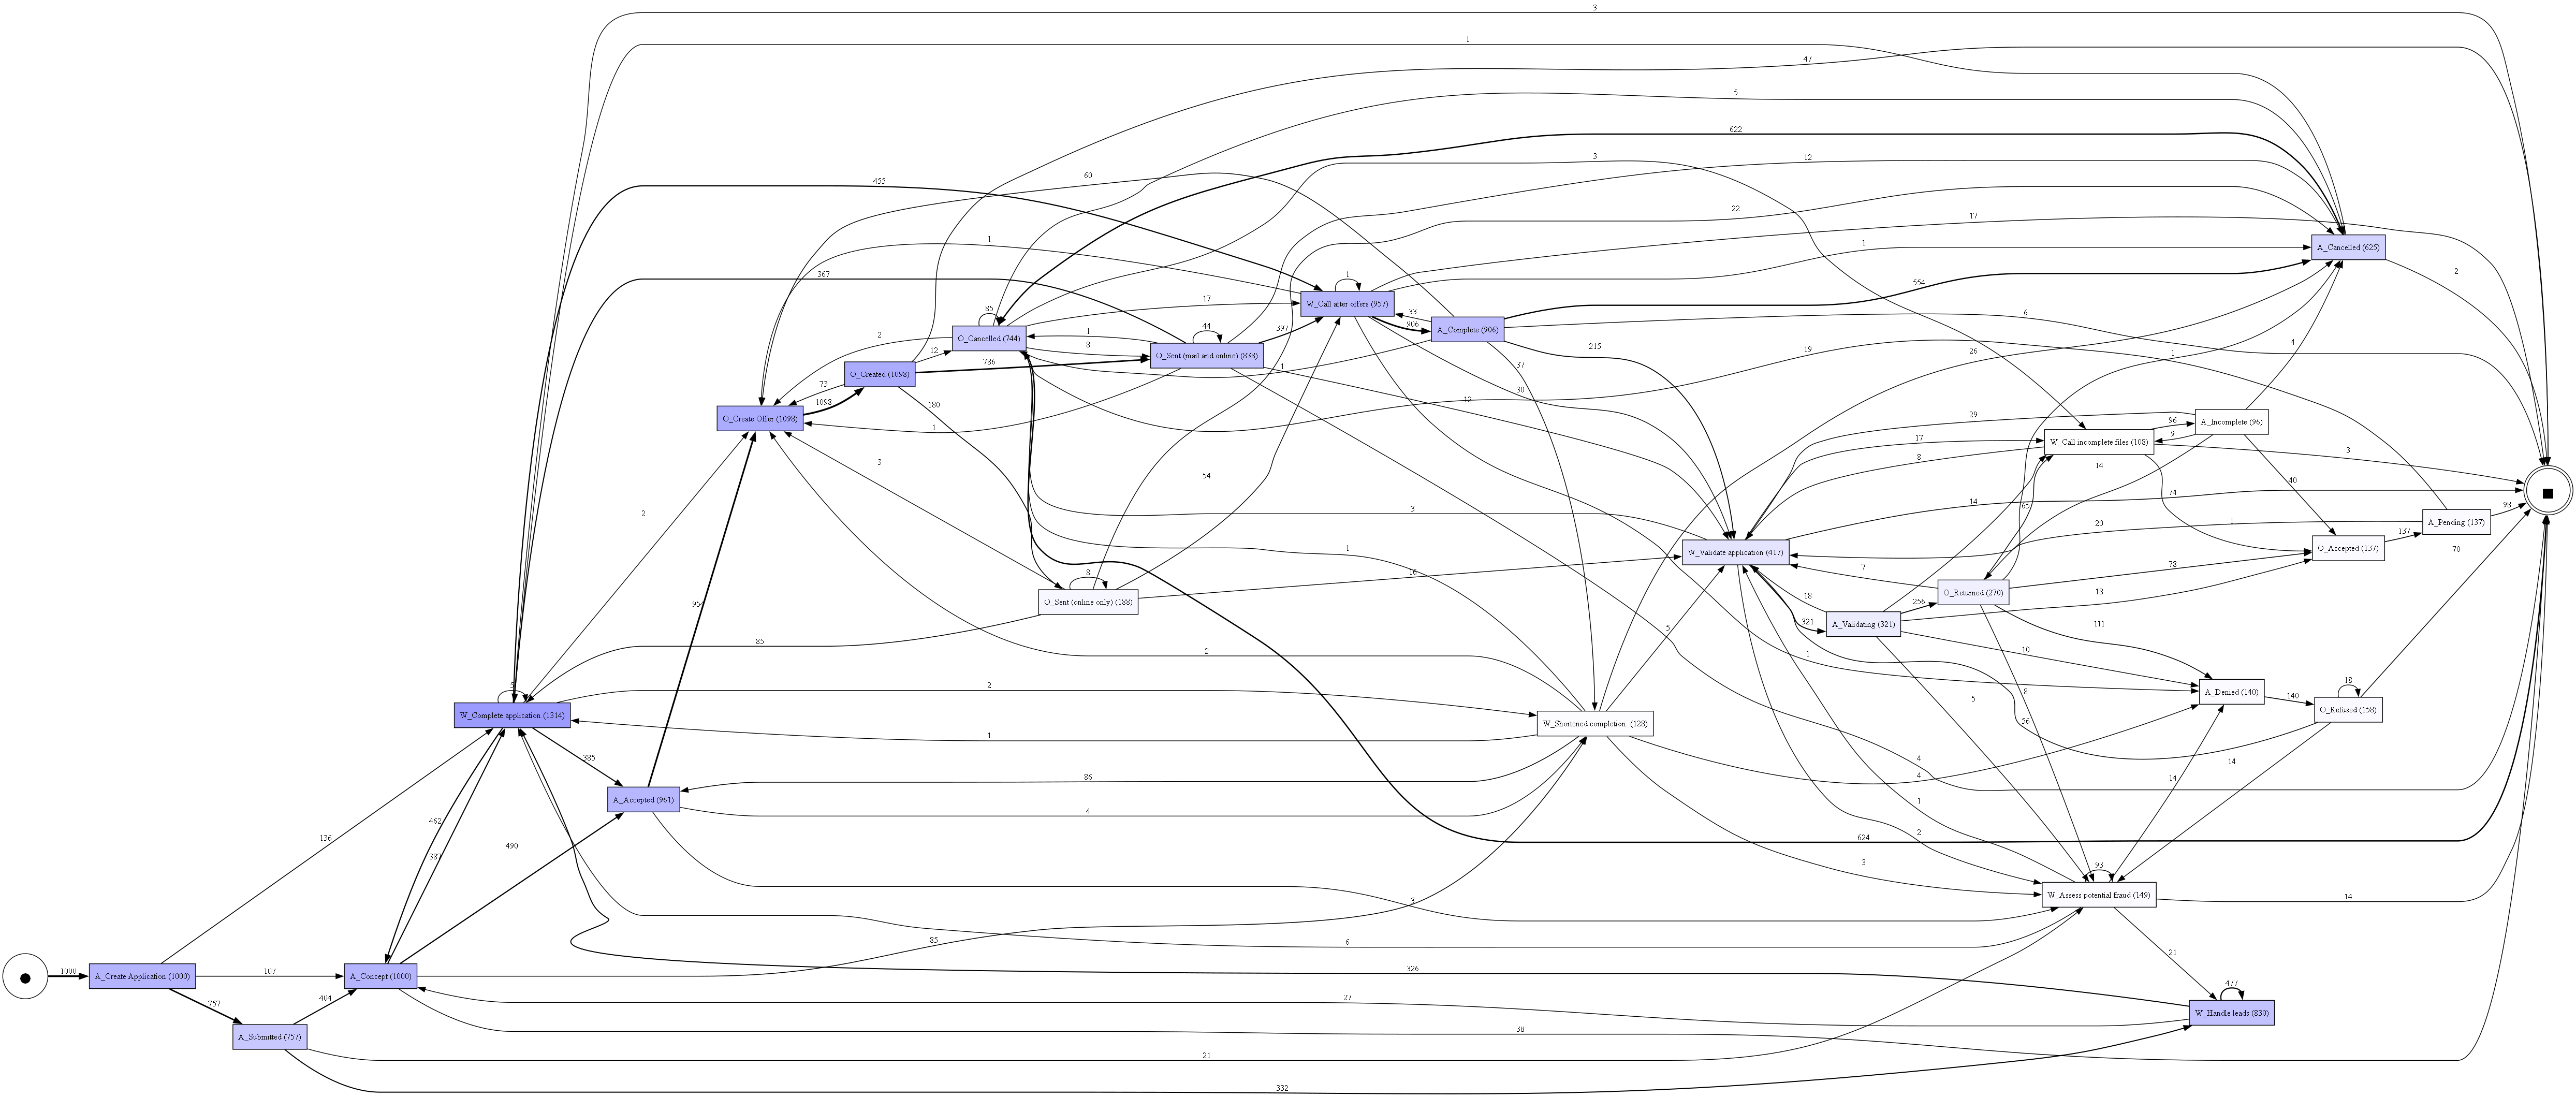

In [10]:
# Visualize Simulation DFG
print("Simulation DFG:")
pm4py.view_dfg(dfg_sim, start_sim, end_sim)

## 6. Edge Comparison (DFG Edges)

In [ ]:
# Compare DFG edges
all_edges = set(dfg_gt.keys()) | set(dfg_sim.keys())

edge_comparison = []
for edge in sorted(all_edges):
    freq_gt = dfg_gt.get(edge, 0)
    freq_sim = dfg_sim.get(edge, 0)
    
    edge_comparison.append({
        'From': edge[0],
        'To': edge[1],
        'GT Freq': freq_gt,
        'Sim Freq': freq_sim,
        'Difference': freq_sim - freq_gt,
        '% Diff': ((freq_sim - freq_gt) / freq_gt * 100) if freq_gt > 0 else (100 if freq_sim > 0 else 0)
    })

edge_df = pd.DataFrame(edge_comparison)

print("="*80)
print("DFG EDGE FREQUENCY COMPARISON")
print("="*80)
print("\nAll edges (sorted by GT frequency):")
display(edge_df.sort_values('GT Freq', ascending=False).head(30))

print("\nEdges with largest absolute differences:")
display(edge_df.sort_values('Difference', key=abs, ascending=False).head(20))

print("\nEdges only in Ground Truth:")
edges_only_gt = edge_df[edge_df['GT Freq'] > 0][edge_df['Sim Freq'] == 0]
print(f"Count: {len(edges_only_gt)}")
display(edges_only_gt.head(10))

print("\nEdges only in Simulation:")
edges_only_sim = edge_df[edge_df['Sim Freq'] > 0][edge_df['GT Freq'] == 0]
print(f"Count: {len(edges_only_sim)}")
display(edges_only_sim.head(10))

## 7. Time-based Analysis

In [ ]:
# Case arrivals over time
df_gt_time = df_gt.copy()
df_gt_time['time:timestamp'] = pd.to_datetime(df_gt_time['time:timestamp'], format='mixed')
arrivals_gt = df_gt_time.groupby('case:concept:name')['time:timestamp'].min()

df_sim_time = df_sim.copy()
df_sim_time['time:timestamp'] = pd.to_datetime(df_sim_time['time:timestamp'], format='mixed')
arrivals_sim = df_sim_time.groupby('case:concept:name')['time:timestamp'].min()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Ground Truth
arrivals_gt.hist(bins=50, ax=axes[0], alpha=0.7, color='orange')
axes[0].set_title('Ground Truth - Case Arrivals Over Time')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Number of Cases')
axes[0].grid(True, alpha=0.3)

# Simulation
arrivals_sim.hist(bins=50, ax=axes[1], alpha=0.7, color='green')
axes[1].set_title('Simulation - Case Arrivals Over Time')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Number of Cases')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Time range comparison
print(f"\nTime Range Comparison:")
print(f"Ground Truth: {arrivals_gt.min()} to {arrivals_gt.max()}")
print(f"Simulation:   {arrivals_sim.min()} to {arrivals_sim.max()}")
print(f"GT Duration: {(arrivals_gt.max() - arrivals_gt.min()).days} days")
print(f"Sim Duration: {(arrivals_sim.max() - arrivals_sim.min()).days} days")

## 8. Processing Time Analysis

In [ ]:
# Calculate processing times per activity using PM4Py
def calculate_processing_times(df, name):
    """Calculate processing times between consecutive events in each case using PM4Py."""
    # Convert to event log
    event_log = pm4py.convert_to_event_log(df)
    
    # Calculate time differences between consecutive events
    processing_times = {}
    
    for trace in event_log:
        for i in range(1, len(trace)):
            prev_event = trace[i-1]
            curr_event = trace[i]
            
            activity = curr_event['concept:name']
            time_diff = (curr_event['time:timestamp'] - prev_event['time:timestamp']).total_seconds() / 3600
            
            if activity not in processing_times:
                processing_times[activity] = []
            processing_times[activity].append(time_diff)
    
    # Calculate statistics per activity
    activity_times = []
    for activity, times in processing_times.items():
        activity_times.append({
            'Activity': activity,
            'count': len(times),
            'mean': np.mean(times),
            'median': np.median(times),
            'std': np.std(times),
            'min': np.min(times),
            'max': np.max(times)
        })
    
    result_df = pd.DataFrame(activity_times).set_index('Activity').round(2)
    
    print(f"\n{name} - Processing Times per Activity (hours):")
    print(f"Total transitions with timing data: {sum(len(times) for times in processing_times.values())}")
    
    return result_df, processing_times

print("="*80)
print("PROCESSING TIME ANALYSIS")
print("="*80)

# Calculate for both logs
proc_times_gt, raw_times_gt = calculate_processing_times(df_gt, "Ground Truth")
proc_times_sim, raw_times_sim = calculate_processing_times(df_sim, "Simulation")

# Combine comparison
proc_comparison = pd.DataFrame({
    'GT_count': proc_times_gt['count'],
    'GT_mean': proc_times_gt['mean'],
    'GT_median': proc_times_gt['median'],
    'Sim_count': proc_times_sim['count'],
    'Sim_mean': proc_times_sim['mean'],
    'Sim_median': proc_times_sim['median']
}).fillna(0)

proc_comparison['Mean_Diff'] = proc_comparison['Sim_mean'] - proc_comparison['GT_mean']
proc_comparison['Median_Diff'] = proc_comparison['Sim_median'] - proc_comparison['GT_median']

print("\nProcessing Time Comparison (sorted by GT count):")
display(proc_comparison.sort_values('GT_count', ascending=False))

In [ ]:
# Calculate accuracy metrics (MAE, MAPE)
common_activities = set(proc_times_gt.index) & set(proc_times_sim.index)

mae_values = []
mape_values = []

for activity in common_activities:
    gt_mean = proc_times_gt.loc[activity, 'mean']
    sim_mean = proc_times_sim.loc[activity, 'mean']
    
    mae = abs(sim_mean - gt_mean)
    mape = abs(sim_mean - gt_mean) / gt_mean * 100 if gt_mean > 0 else 0
    
    mae_values.append(mae)
    mape_values.append(mape)

print("\n" + "="*80)
print("PROCESSING TIME ACCURACY METRICS")
print("="*80)
print(f"Mean Absolute Error (MAE): {np.mean(mae_values):.2f} hours")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(mape_values):.2f}%")
print(f"Median Absolute Error: {np.median(mae_values):.2f} hours")
print(f"Median Absolute Percentage Error: {np.median(mape_values):.2f}%")

In [ ]:
# Box plots for top activities
top_activities = proc_times_gt.sort_values('count', ascending=False).head(10).index.tolist()

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for idx, activity in enumerate(top_activities):
    ax = axes[idx]
    
    data_to_plot = []
    labels = []
    
    if activity in raw_times_gt:
        data_to_plot.append(raw_times_gt[activity])
        labels.append('GT')
    
    if activity in raw_times_sim:
        data_to_plot.append(raw_times_sim[activity])
        labels.append('Sim')
    
    if data_to_plot:
        bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
        
        # Color boxes
        colors = ['orange', 'green']
        for patch, color in zip(bp['boxes'], colors[:len(data_to_plot)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        ax.set_title(f"{activity[:30]}.." if len(activity) > 30 else activity, fontsize=9)
        ax.set_ylabel('Processing Time (hours)', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=8)

plt.suptitle('Processing Time Distributions - Top 10 Activities by Frequency', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Scatter plot: GT vs Simulation mean processing times
common_activities = set(proc_times_gt.index) & set(proc_times_sim.index)

gt_means = [proc_times_gt.loc[act, 'mean'] for act in common_activities]
sim_means = [proc_times_sim.loc[act, 'mean'] for act in common_activities]

plt.figure(figsize=(10, 10))
plt.scatter(gt_means, sim_means, alpha=0.6, s=100)

# Add diagonal line (perfect prediction)
max_val = max(max(gt_means), max(sim_means))
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction', linewidth=2)

plt.xlabel('Ground Truth Mean Processing Time (hours)', fontsize=12)
plt.ylabel('Simulation Mean Processing Time (hours)', fontsize=12)
plt.title('Processing Time Prediction Accuracy\n(Mean times per activity)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation
correlation = np.corrcoef(gt_means, sim_means)[0, 1]
print(f"\nCorrelation between GT and Sim mean processing times: {correlation:.3f}")

## 9. Summary Report

In [ ]:
print("="*80)
print("GROUND TRUTH vs SIMULATION - SUMMARY REPORT")
print("="*80)

print(f"\n📊 VOLUMETRIC COMPARISON:")
print(f"  Ground Truth: {len(df_gt)} events, {df_gt['case:concept:name'].nunique()} cases")
print(f"  Simulation:   {len(df_sim)} events, {df_sim['case:concept:name'].nunique()} cases")
print(f"  Difference:   {len(df_sim) - len(df_gt):+d} events ({(len(df_sim) - len(df_gt)) / len(df_gt) * 100:+.1f}%), "
      f"{df_sim['case:concept:name'].nunique() - df_gt['case:concept:name'].nunique():+d} cases "
      f"({(df_sim['case:concept:name'].nunique() - df_gt['case:concept:name'].nunique()) / df_gt['case:concept:name'].nunique() * 100:+.1f}%)")

print(f"\n🔄 ACTIVITY ANALYSIS:")
activities_gt = set(df_gt['concept:name'].unique())
activities_sim = set(df_sim['concept:name'].unique())
common_activities = activities_gt & activities_sim
print(f"  Activities in GT:  {len(activities_gt)}")
print(f"  Activities in Sim: {len(activities_sim)}")
print(f"  Common activities: {len(common_activities)}")
print(f"  Coverage: {len(common_activities) / len(activities_gt) * 100:.1f}%")

if activities_gt - activities_sim:
    print(f"  Missing in Sim: {activities_gt - activities_sim}")
if activities_sim - activities_gt:
    print(f"  Extra in Sim: {activities_sim - activities_gt}")

print(f"\n🔀 VARIANT ANALYSIS:")
print(f"  Variants in GT:  {len(variants_gt)}")
print(f"  Variants in Sim: {len(variants_sim)}")
print(f"  Common variants: {len(common_variants)}")
print(f"  Coverage: {len(variants_sim) / len(variants_gt) * 100:.1f}%")

print(f"\n🔗 DFG EDGE ANALYSIS:")
print(f"  Edges in GT:  {len(dfg_gt)}")
print(f"  Edges in Sim: {len(dfg_sim)}")
print(f"  Coverage: {len(dfg_sim) / len(dfg_gt) * 100:.1f}%")

print(f"\n⏱️  PROCESSING TIME ACCURACY:")
print(f"  MAE:  {np.mean(mae_values):.2f} hours")
print(f"  MAPE: {np.mean(mape_values):.2f}%")
print(f"  Correlation: {correlation:.3f}")

print(f"\n⏳ CASE DURATION:")
print(f"  GT Avg:  {stats_gt['Avg Case Duration (hours)']:.2f} hours")
print(f"  Sim Avg: {stats_sim['Avg Case Duration (hours)']:.2f} hours")
print(f"  Difference: {stats_sim['Avg Case Duration (hours)'] - stats_gt['Avg Case Duration (hours)']:+.2f} hours "
      f"({(stats_sim['Avg Case Duration (hours)'] - stats_gt['Avg Case Duration (hours)']) / stats_gt['Avg Case Duration (hours)'] * 100:+.1f}%)")

print("\n" + "="*80)
print("✓ Comparison completed successfully")
print("="*80)